In [1]:
from keras.preprocessing import image
from keras.models import Model, Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Dropout
from keras import backend as K
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX 1060 6GB (CNMeM is disabled, cuDNN 5110)


In [10]:
model = Sequential()

model.add(Conv2D(filters=64, kernel_size=(11, 11), activation="relu", input_shape=(3, 256, 256)))
#model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
#model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=(5, 5), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
#model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation="relu"))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
#model.add(Conv2D(filters=64, kernel_size=(3, 3), activation="relu"))
#model.add(Conv2D(filters=64, kernel_size=(3, 3), activation="relu"))
model.add(Flatten())

model.add(Dense(256, activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(256, activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(2, activation="softmax"))

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 64, 246, 246)      23296     
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 64, 242, 242)      102464    
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 64, 121, 121)      0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 64, 119, 119)      36928     
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 64, 117, 117)      36928     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 64, 58, 58)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 215296)            0         
__________

In [11]:
# define the dataflow
batch_size = 16
IDG = ImageDataGenerator()
train_batch = IDG.flow_from_directory("./data/train/", target_size=(256, 256), 
                    class_mode='categorical', batch_size=batch_size, shuffle=True)
valid_batch = IDG.flow_from_directory("./data/valid/", target_size=(256, 256),
                    class_mode="categorical", batch_size=batch_size, shuffle=True)

Found 25230 images belonging to 2 classes.
Found 6062 images belonging to 2 classes.


In [12]:
model.fit_generator(train_batch, steps_per_epoch=train_batch.samples // batch_size, epochs=30,
                   validation_data=valid_batch, validation_steps=valid_batch.samples // batch_size)

Epoch 1/30
1576/1576 [==============================] - 884s - loss: 0.7972 - acc: 0.5138 - val_loss: 0.7292 - val_acc: 0.4735
Epoch 2/30
1576/1576 [==============================] - 903s - loss: 0.7105 - acc: 0.5120 - val_loss: 0.7323 - val_acc: 0.5017
Epoch 3/30
1576/1576 [==============================] - 900s - loss: 0.7095 - acc: 0.5132 - val_loss: 0.7130 - val_acc: 0.5318
Epoch 4/30
1576/1576 [==============================] - 907s - loss: 0.7059 - acc: 0.5215 - val_loss: 0.6959 - val_acc: 0.5367
Epoch 5/30
1576/1576 [==============================] - 909s - loss: 0.7064 - acc: 0.5162 - val_loss: 0.7068 - val_acc: 0.5195
Epoch 6/30
1576/1576 [==============================] - 910s - loss: 0.7041 - acc: 0.5142 - val_loss: 0.7012 - val_acc: 0.5154
Epoch 7/30
1576/1576 [==============================] - 910s - loss: 0.7023 - acc: 0.5183 - val_loss: 0.7133 - val_acc: 0.4998
Epoch 8/30
1576/1576 [==============================] - 910s - loss: 0.6999 - acc: 0.5266 - val_loss: 0.7177 - 

In [6]:
model.save_weights("./data/CNN_from_scratch.h5")

In [ ]:
model.load_weights("./data/CN_from_scratch.h5")

In [16]:
# predict for test
test_batch = IDG.flow_from_directory("./data/valid/", target_size=(256, 256),
                    class_mode="categorical", batch_size=16, shuffle=False)
predict_prob = model.predict_generator(test_batch, steps=test_batch.samples // 16 + 1)

Found 6062 images belonging to 2 classes.


In [17]:
# test spearman correlation
import os
import numpy as np
from scipy.stats import spearmanr

img_score = {}
with open("../data/img_score.csv", 'r') as fin:
    for line in fin:
        imgid, score = line.strip().split("\t")
        img_score[imgid] = float(score)
        
def get_imgid(filename):
    filename = os.path.basename(filename)
    return os.path.splitext(filename)[0]

true_score = []
predict_score = []
for i, filename in enumerate(test_batch.filenames):
    imgid = get_imgid(filename)
    if img_score[imgid] > 1 or img_score[imgid] < -1:
        true_score.append(img_score[imgid])
        predict_score.append(predict_prob[i, 1])
true_score = np.array(true_score)
predict_score = np.array(predict_score)

print spearmanr(predict_score, true_score)
print sum(true_score[predict_score>0.5]>1) * 1.0 / len(true_score[predict_score>0.5])

SpearmanrResult(correlation=0.072390690892946905, pvalue=0.0025964350612031535)
0.542735042735


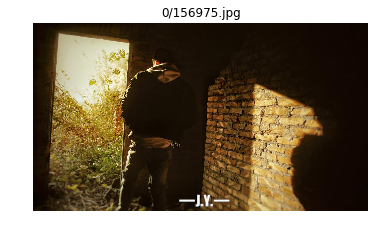

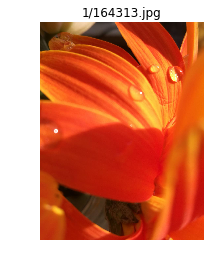

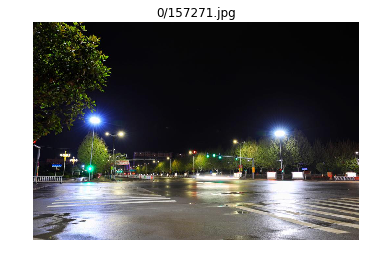

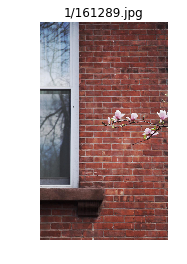

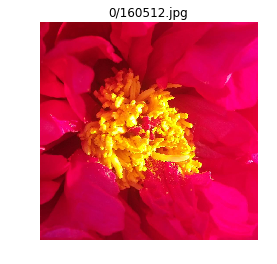

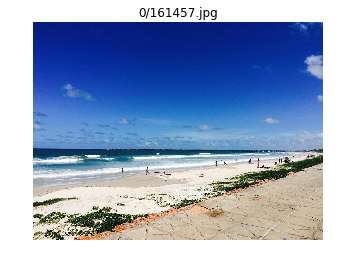

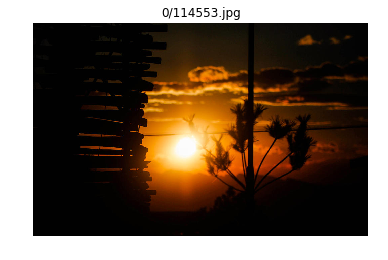

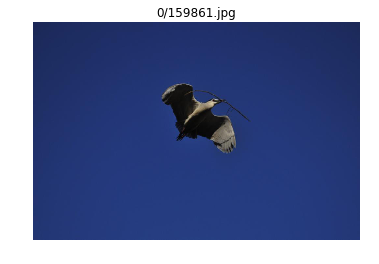

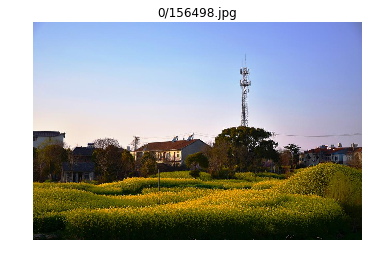

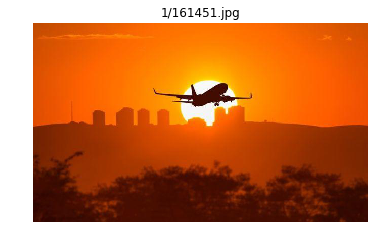

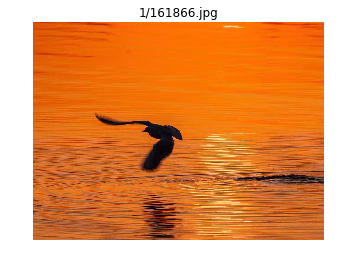

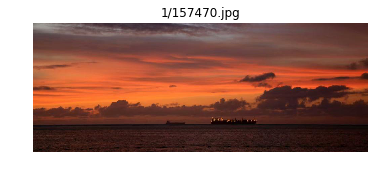

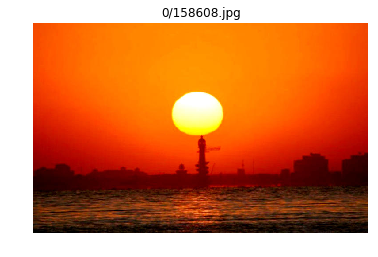

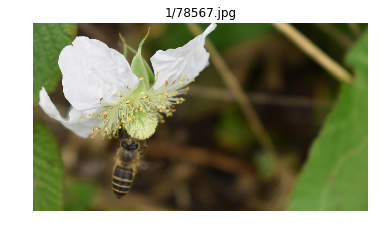

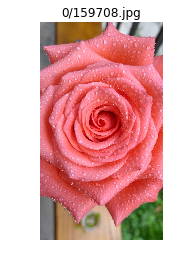

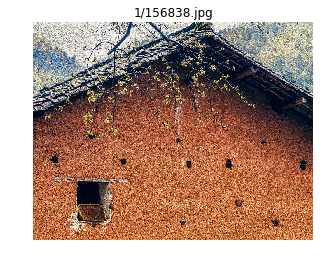

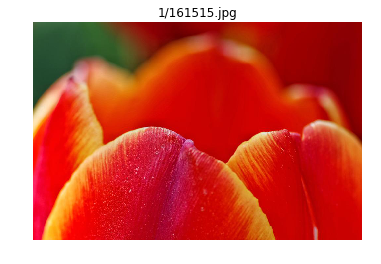

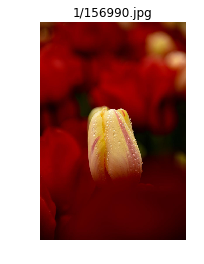

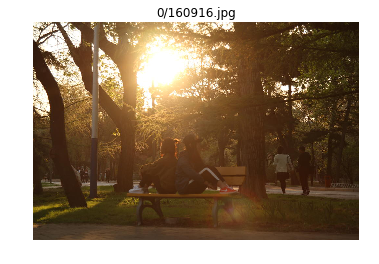

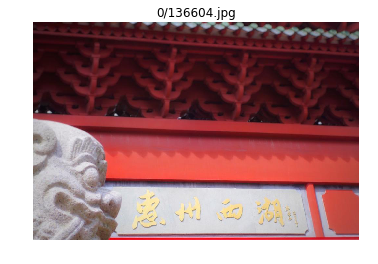

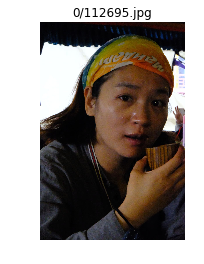

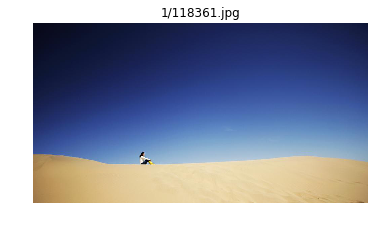

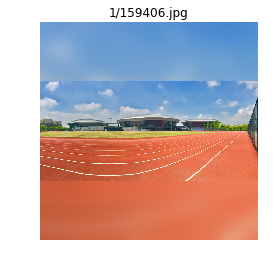

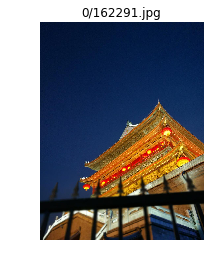

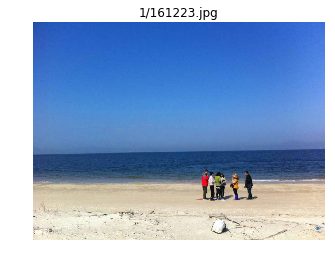

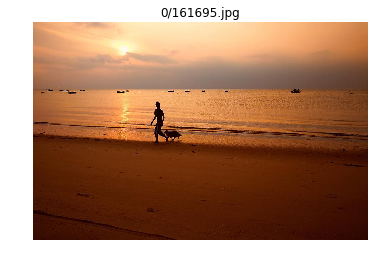

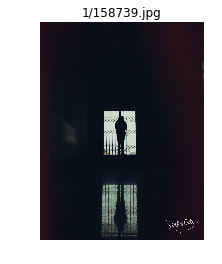

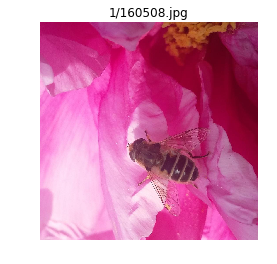

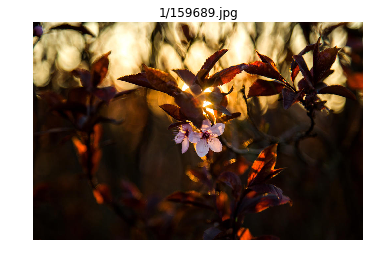

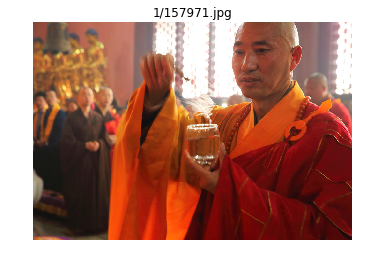

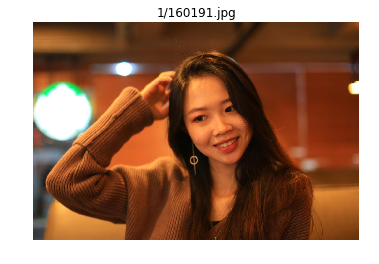

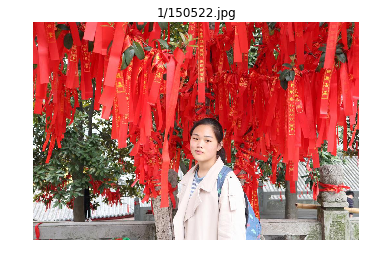

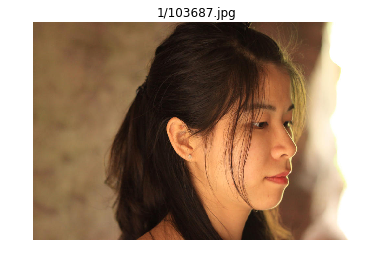

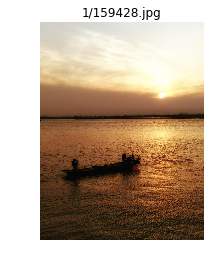

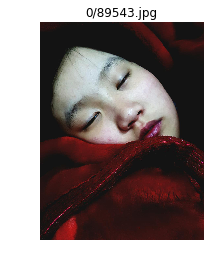

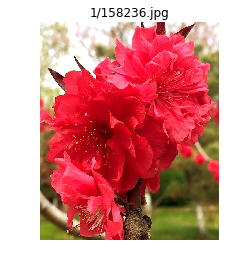

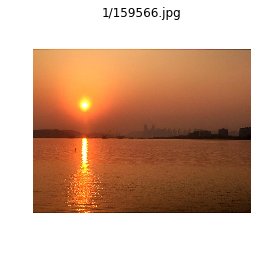

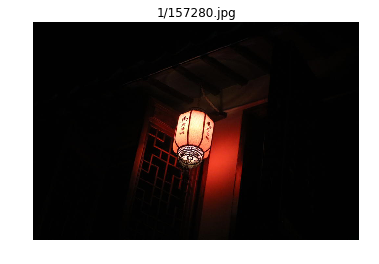

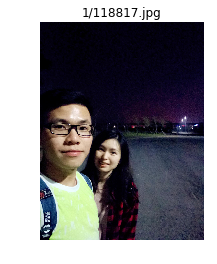

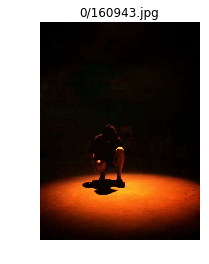

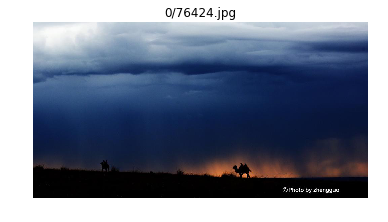

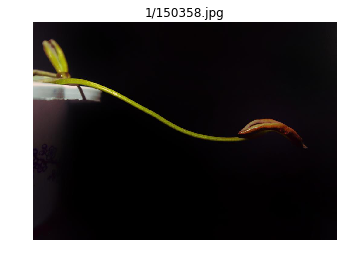

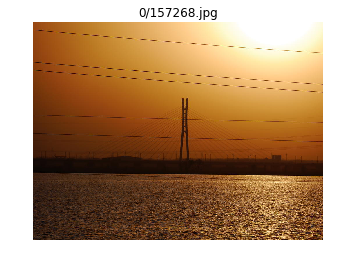

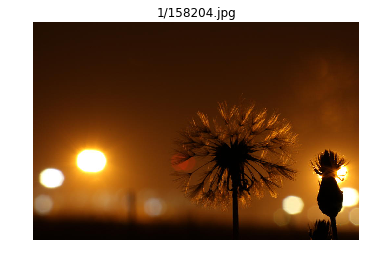

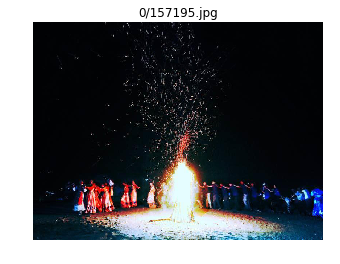

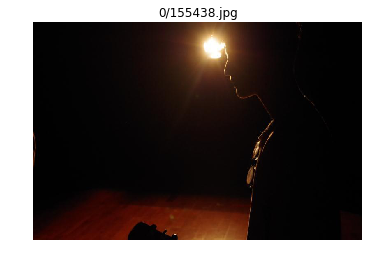

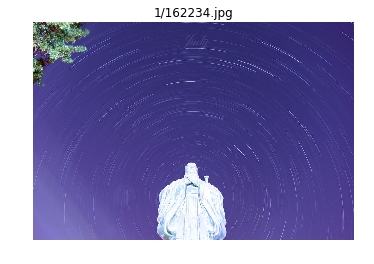

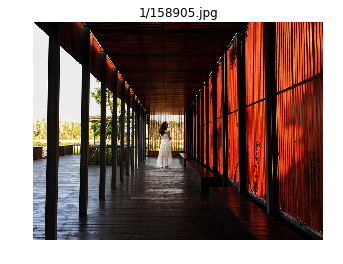

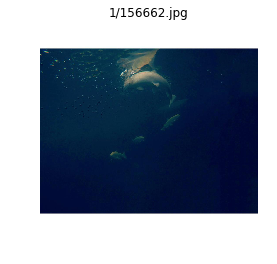

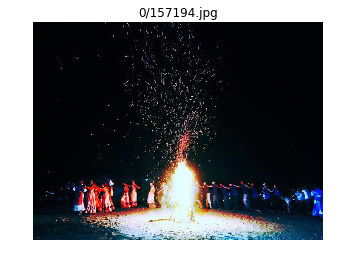

In [18]:
# demo show
%matplotlib inline
from PIL import Image
import matplotlib.pyplot as plt

def testPlot(img_filename):
    plt.figure()
    
    plt.title(img_filename)
    img = Image.open("./data/valid/%s"%img_filename)
    plt.imshow(img)
    plt.axis('off')
    
    plt.show()
    
sorted_idx = np.argsort(predict_prob[:, 1])
low_picid = sorted_idx[:30]
high_picid = sorted_idx[-50:]
for _id in high_picid:
    testPlot(test_batch.filenames[_id])